## Notebook to explore downloaded metadata from Mapillary

In [1]:
from streetscapes.streetview import SVWorkspace
from streetscapes.utils import get_env, plot_metadata

In [2]:
ws = SVWorkspace("amsterdam")
metadata = ws.load_metadata('mapillary.parquet')
metadata

,id,altitude,atomic_scale,camera_type,captured_at,compass_angle,computed_altitude,computed_compass_angle,computed_rotation,exif_orientation,...,computed_geometry.type,computed_geometry.coordinates,creator.username,creator.id,geometry.type,geometry.coordinates,lon,lat,geometry,source
0,586782806046448,0.00,0.995286,perspective,1588769656020,221.450475,2.027283,226.614130,"[0.71513766958889, 1.6438866201519, -1.8163302...",1,...,Point,"[4.7028837195047, 52.257496899976]",Lowiekse,103198898589938,Point,"[4.7028898999972, 52.2575]",4.702890,52.257500,POINT (4.70289 52.2575),mapillary
1,1131533837329921,0.00,0.995356,perspective,1588769654008,222.557201,1.981281,227.038154,"[0.7240492837576, 1.6439866940554, -1.80886699...",1,...,Point,"[4.7031391475994, 52.257676103714]",Lowiekse,103198898589938,Point,"[4.7031299000024, 52.257669900001]",4.703130,52.257670,POINT (4.70313 52.25767),mapillary
2,1561057877681657,0.00,0.980278,perspective,1659953371363,32.826632,5.845891,34.401799,"[1.5201303052351, -0.47305814867026, 0.4676378...",1,...,Point,"[4.7090524813916, 52.251889532083]",Lowiekse,103198898589938,Point,"[4.7090270798437, 52.251953100002]",4.709027,52.251953,POINT (4.70903 52.25195),mapillary
3,774217783456568,0.00,1.015706,perspective,1588769636096,220.831425,1.972134,229.146108,"[0.74934924985998, 1.6009228236207, -1.8022008...",1,...,Point,"[4.7051873591295, 52.259086242311]",Lowiekse,103198898589938,Point,"[4.7051799000027, 52.259079899998]",4.705180,52.259080,POINT (4.70518 52.25908),mapillary
4,1046040943353916,0.00,1.008592,perspective,1704629027173,218.349167,1.375648,223.471322,"[0.70474494937592, 1.7661919381878, -1.7864132...",1,...,Point,"[4.7009658410889, 52.256123037629]",Lowiekse,103198898589938,Point,"[4.700971, 52.2561245]",4.700971,52.256124,POINT (4.70097 52.25612),mapillary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,727106287967920,0.00,1.602090,perspective,1280670834000,-1.000000,2.161161,77.401786,"[1.3121600769346, -1.0390996640274, 1.05439744...",1,...,Point,"[5.0987658680857, 52.457024115854]",txllxt,102278692017260,Point,"[5.0987277777778, 52.456991666667]",5.098728,52.456992,POINT (5.09873 52.45699),mapillary
57,781778642473384,0.00,127.156178,perspective,1280670106000,-1.000000,2.000726,95.579275,"[-2.2274731625183, 2.5768027962775, -2.3326287...",1,...,Point,"[5.092667027105, 52.451321069225]",txllxt,102278692017260,Point,"[5.0928083333333, 52.451383333333]",5.092808,52.451383,POINT (5.09281 52.45138),mapillary
0,1022065869799254,0.00,1.000000,perspective,1741617159666,114.492752,-7.469210,111.591472,"[1.00526992517, -1.4798492467845, 1.4817477728...",1,...,Point,"[5.0999747930897, 52.316373959845]",thewizard,106617448243381,Point,"[5.0999999666667, 52.316368266667]",5.100000,52.316368,POINT (5.1 52.31637),mapillary
1,991235186418855,-0.63,0.992306,perspective,1750074889900,292.450000,1.516671,57.825459,"[1.4158994721199, -0.76821945060021, 0.8030029...",1,...,Point,"[5.1002190738453, 52.316698551241]",thewizard,106617448243381,Point,"[5.1000001, 52.3167587]",5.100000,52.316759,POINT (5.1 52.31676),mapillary


<Axes: >

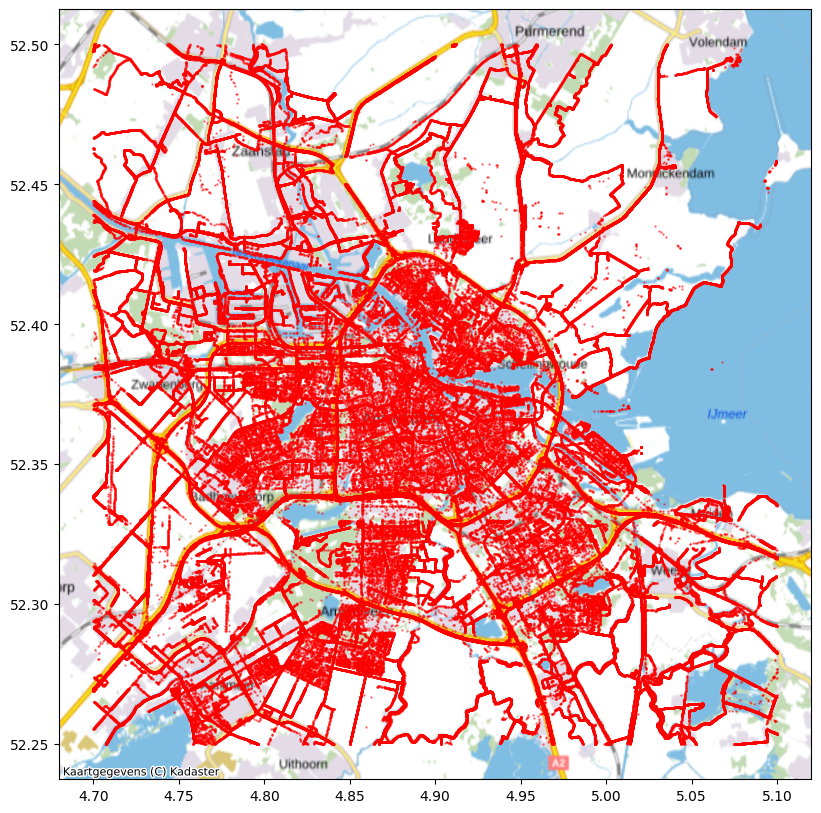

In [3]:
plot_metadata(metadata)

Let's enrich the metadata a bit. Add

- whether images have already been downloaded ('is_local')
- captured at as proper datetime
- captured at as simple string format

In [3]:
# Locally available images

from pathlib import Path

image_dir = Path(get_env('DATA_HOME')) / 'sources' / 'mapillary' / 'images'
existing_ids = {p.stem for p in image_dir.glob('*.jpeg')}
metadata['is_local'] = metadata['id'].isin(existing_ids)

local_images = metadata.query('is_local')
print(f"{len(local_images)} images out of {len(metadata)} available locally.")

96006 images out of 362442 available locally.


In [4]:
# Datetime formatting

from datetime import datetime, timezone

metadata['captured_at_dt'] = metadata['captured_at'].apply(
    lambda ms: datetime.fromtimestamp(ms / 1000, tz=timezone.utc)
)
metadata['captured_at_str'] = metadata['captured_at_dt'].apply(
    lambda dt: dt.strftime('%Y%m%d%H%M%S')
)

<Axes: >

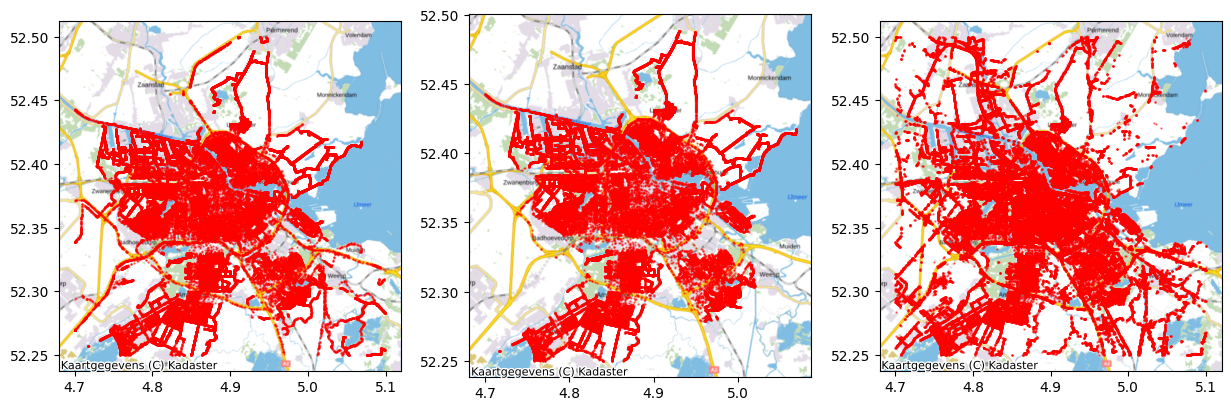

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_metadata(metadata.query('is_pano'), ax=axs[0])
plot_metadata(metadata.query('`creator.username` == "amsterdam"'), ax=axs[1])
plot_metadata(metadata.query('is_local'), ax=axs[2])

## Complex queries

These are all the columns that are currently available

In [7]:
metadata.columns

Index(['id', 'altitude', 'atomic_scale', 'camera_type', 'captured_at',
       'compass_angle', 'computed_altitude', 'computed_compass_angle',
       'computed_rotation', 'exif_orientation', 'height', 'is_pano', 'make',
       'model', 'thumb_256_url', 'thumb_1024_url', 'thumb_2048_url',
       'thumb_original_url', 'sequence', 'width', 'computed_geometry.type',
       'computed_geometry.coordinates', 'creator.username', 'creator.id',
       'geometry.type', 'geometry.coordinates', 'lon', 'lat', 'geometry',
       'source', 'is_local', 'captured_at_dt', 'captured_at_str'],
      dtype='object')

Instead of chaining queries, we can also combine them.

In [8]:
chained_query = metadata.query("is_pano").query("compass_angle>315").query('captured_at_str.str.startswith("202")')

pano = "is_pano"
northwest = "compass_angle > 315"
twenties = 'captured_at_str.str.startswith("202")'

combined_query = metadata.query(f"{pano}&{northwest}&{twenties}")

## Creating a representative sample

Let's create a sample that's still adequate for converting to LCZs. We will load an example LCZ map, and make sure to obtain roughly uniform sampling across the LCZ raster. 

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Open LCZ map
lcz_path = '/projects/prjs0914/dragan/amsterdam_lcz_kittner_081/LCZ/ams_lcz_kittner_081.tif'

with rasterio.open(lcz_path) as src:
    lcz_crs = src.crs
    lcz_transform = src.transform
    lcz_shape = (src.height, src.width)
    lcz_data = src.read(1)  # Read the first band

# Only consider panoramas uploaded by municipality username
municipality_images = metadata.query('`creator.username` == "amsterdam" & is_pano')

# Reproject metadata to match LCZ raster
reprojected = metadata.to_crs(lcz_crs)

# Add column to the geodataframe corresponding to the pixel index in the LCZ raster
coords = np.array([(geom.x, geom.y) for geom in reprojected.geometry])
cols, rows = ~lcz_transform * (coords[:, 0], coords[:, 1])
rows = rows.astype(int)
cols = cols.astype(int)
cell_ids = rows * lcz_shape[1] + cols
reprojected = reprojected.assign(raster_cell=cell_ids)

# Add LCZ classes to the metadata and exclude rural classes
reprojected['lcz_class'] = lcz_data[rows, cols]
urban_images = reprojected.query('lcz_class <= 10')

# Do stratified sampling: sample fixed number per raster cell
sample_per_cell = 5  # adjust as needed
sample = urban_images.groupby('raster_cell').apply(
    lambda df: df.sample(n=min(len(df), sample_per_cell), random_state=42)
).reset_index(drop=True)

print(f"Sampled {len(sample)} points with spatial stratification by raster cells.")


Sampled 96054 points with spatial stratification by raster cells.


/scratch-local/69026/ipykernel_3540799/4159960126.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = urban_images.groupby('raster_cell').apply(


(52.24999837, 52.5000018)

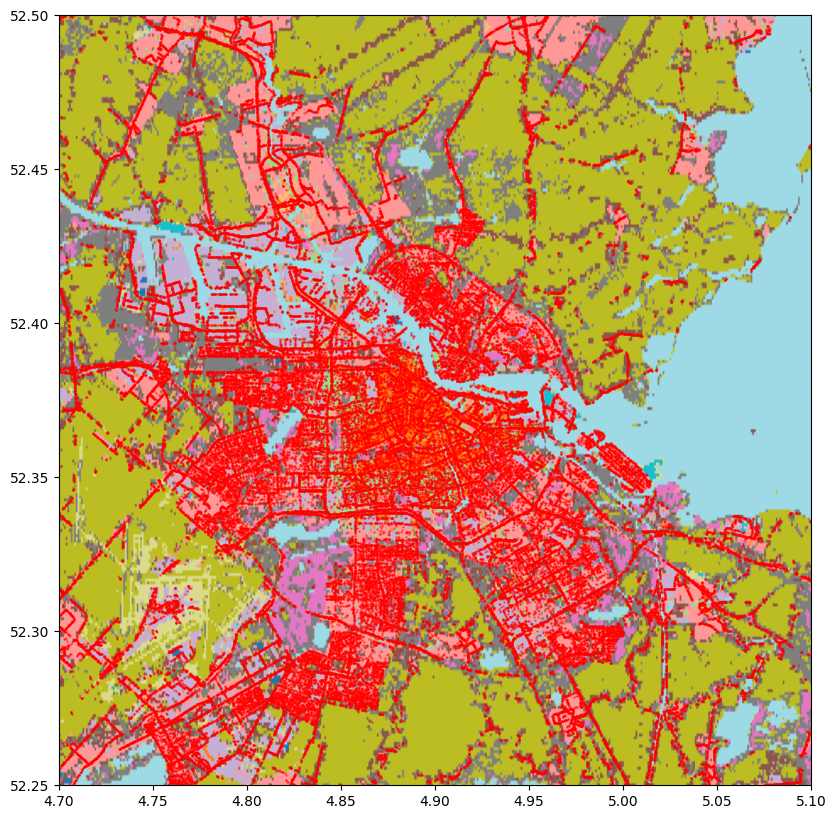

In [10]:
# Visualize the result
left, top = lcz_transform * (0, 0)
right, bottom = lcz_transform * (lcz_data.shape[1], lcz_data.shape[0])
extent = (left, right, bottom, top)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(lcz_data, cmap='tab20', extent=extent, origin='upper')
sample.plot(ax=ax, markersize=.5, alpha=0.5, color='red')

xmin, ymin, xmax, ymax = reprojected.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

In [99]:
# Store subset of metadata for further processing
ws.save_metadata(sample, 'subset_lcz_kittner_081.parquet')

Streetscapes | 2025-08-08@15:09:45 | Metadata saved to /gpfs/work4/0/prjs0914/streetscapes/data/workspaces/amsterdam/subset_lcz_kittner_081.parquet


In [ ]:
# %%submit_to_slurm time=12:00:00 partition=staging filename=download_images.py submit=True
"""
This cell is meant to be run as a separate script, not inside the notebook.
Executing this cell stores the code contained in it in a file named `download_images.py`.
To run the script, the submit it as a batch job in the next cell.
"""
from streetscapes.sources import Mapillary
from streetscapes.streetview import SVWorkspace

ws = SVWorkspace("amsterdam")
metadata = ws.load_metadata('subset_lcz_kittner_081.parquet')

mp = Mapillary()
ids = metadata["id"].to_list()
urls = metadata["thumb_2048_url"].to_list()
paths = mp.download_images(ids, urls)

'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
Streetscapes | 2025-08-10@08:05:00 | Failed to download image 6579065885469634:
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
'thumb_2048_url'
Streetscapes | 2025-08-10@08:06:39 | Failed to download image 801301931363813:
'thumb_2048_url'
Streetscapes | 2025-08-10@08:06:39 | Failed to download image 1408193243349374:
'thumb_2048_url'
Streetscapes | 2025-08-10@08:06:40 | Failed to download image 800035351625085:
'thumb_2048_url'
Streetscapes | 2025-08-10@08:06:40 | Failed to download image 995084601514946:
'thumb_2048_url'
Streetscapes | 2025-08-10@08:06:40 | Failed to download image 564208102591444:
'thumb_2048_url'
Streetscapes | 2025-08-10@08:06:41 | Failed to download image 680

# Step 3: Segment images

In [ ]:
from streetscapes.streetview import SVWorkspace
from streetscapes.models import DinoSAM
from streetscapes.utils import get_env
from pathlib import Path

ws = SVWorkspace("amsterdam")
metadata = ws.load_metadata('subset_lcz_kittner_081.parquet')

image_dir = Path(get_env('DATA_HOME')) / 'sources' / 'mapillary' / 'images'

existing_images = {p.stem for p in image_dir.glob('*.jpeg')}
local_images = metadata[metadata['id'].isin(existing_images)]['id'].to_list()
image_paths = [image_dir / f"{id}.jpeg" for id in local_images]

model = DinoSAM()

labels = {
    "building": {
        "window": None,
        "door": None,
    },
    "vegetation": None,
    "car": None,
    "truck": None,
    "road": None,
}

segmentations = model.segment(image_paths, labels, batch_size=25)

In [6]:
!ls /projects/prjs0914/streetscapes/data/sources/mapillary/images/segmentations/dinosam/ -rtl | tail

-rw-rw----. 1 pkalverla1 prjs0914  34637 Aug 12 01:55 513552256492207.npz
-rw-rw----. 1 pkalverla1 prjs0914  28440 Aug 12 01:55 482460954583206.npz
-rw-rw----. 1 pkalverla1 prjs0914  41978 Aug 12 01:55 4460055894110233.npz
-rw-rw----. 1 pkalverla1 prjs0914  56987 Aug 12 01:55 1203036834895403.npz
-rw-rw----. 1 pkalverla1 prjs0914  44126 Aug 12 01:55 475275597046949.npz
-rw-rw----. 1 pkalverla1 prjs0914  38258 Aug 12 01:55 1867060150132148.npz
-rw-rw----. 1 pkalverla1 prjs0914  23357 Aug 12 01:55 1647388765890663.npz
-rw-rw----. 1 pkalverla1 prjs0914  73910 Aug 12 01:55 753569508657597.npz
-rw-rw----. 1 pkalverla1 prjs0914 106220 Aug 12 01:55 757662014923648.npz
-rw-rw----. 1 pkalverla1 prjs0914  88037 Aug 12 01:55 2495329917284808.npz


(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

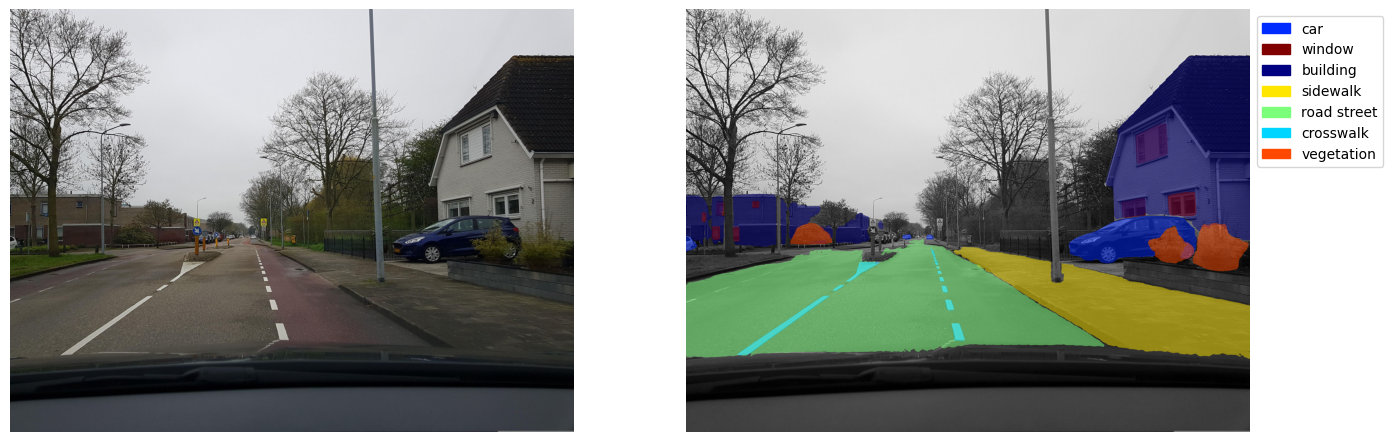

In [7]:
from pathlib import Path
from streetscapes.streetview import SVSegmentation

segmentations_path = Path('/projects/prjs0914/streetscapes/data/sources/mapillary/images/segmentations/dinosam')
image_id = '2495329917284808'

segmentation = SVSegmentation(segmentations_path / f'{image_id}.npz')
segmentation.visualise()

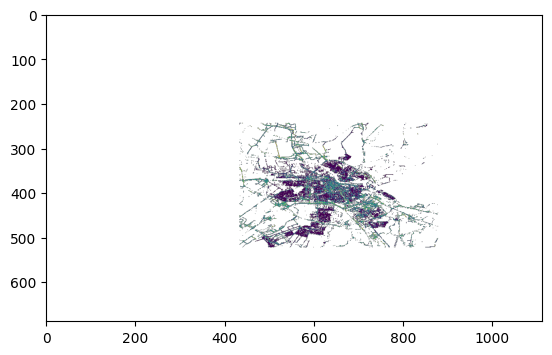

In [ ]:
# Rasterize a random column from the sample data onto the LCZ raster
agg = sample.groupby('raster_cell')['compass_angle'].mean().reset_index()
rows = agg['raster_cell'] // lcz_shape[1]
cols = agg['raster_cell'] % lcz_shape[1]

raster_out = np.full(lcz_shape, np.nan, dtype=float)
raster_out[rows, cols] = agg['compass_angle']

In [ ]:
# Calculate LCZ table statistics
sample.groupby('lcz_class')['compass_angle'].agg(['mean', 'count'])

,mean,count
lcz_class,,
0,76.673954,107
2,102.443197,7437
3,107.610667,1004
5,96.757328,7515
6,94.257413,43618
8,102.896825,13980
9,128.738338,22393
